### 正規分布のCDFを返す関数

### 求解方法

複数の根をもつ方程式の複数の根を求める関数はpythonには無い。

３本方程式で求める方法はnewton法の実装を使うのが一番近い。

解の探索範囲は$[0,1]$なので、適当にグリッドを区切って解を探す。

誤差を小さくすれば、複数の解があるとなっても、解析的な解と一致する

### Fig1aのコードの再利用

Fig1aのコードを再利用する。
Rを正規分布のmeanとして扱う。
scleに何らかの値が入れば、閾値が分布する場合になるようにする。

In [171]:

from scipy.special import comb
from scipy.special import factorial
from scipy.stats import norm
import numpy as np
from numba import jit, int32, float32

@jit#(float32(float32, float32, float32, int32, NoneType))
def g(k, q, R, last=False, scale = 0.2, diff = 0):
    '''
        if scale is not None, threshold is treated as a random variables.
        In that case, `R`and `scale` are parameters of normal distribution, where
        R is mean and scale is deviation.
    '''
    m_array = np.arange(0., k + 1, 1) #from 0 to k
    comb_k_m = comb(k, m_array)
    if(scale == None): threshold_array =  (m_array/k) > R
    else: threshold_array = norm(R, scale).cdf(m_array/k)
    if(diff == 0): X = comb_k_m * (q**m_array)*((1-q)**(k-m_array))
    if(diff == 1): X = comb_k_m * q**(m_array-1)*(-q+1)**(k-m_array-2)*(-k*q+m_array+q)
    elif(diff == 2): X = (-q**(m_array-2)*(1-q)**(k-m_array-3)) *(-k**2*q**2+2*k*m_array*q+3*k*q**2-m_array**2-4*m_array*q+m_array-2*q**2)
    return(np.sum(X * threshold_array))
    
@jit#(float32(float32, float32, float32, int32, int32))
def G(q, R, z, k_max=20, last=False, scale = 0.2, diff = 0):
    k_array = np.arange(1.0, k_max + 1, 1) # from 1 to k_max
    k_array = np.linspace(1, k_max + 1, 10)
    pk = np.exp(-z)*(z**k_array)/factorial(k_array)
    if(not last): pk = pk*(k_array/z)   
    for i, k in enumerate(k_array):
        pk[i] = pk[i]*g(k, q, R, last, scale, diff)
    return(np.sum(pk))


### 1~2階微分の式を定義しておく

In [172]:
f = lambda q, R, z: -q + G(q, R, z)
fd = lambda q, R, z: -1 + G(q, R, z,diff = 1)
fdd = lambda q, R, z: G(q, R, z, diff = 2)

### 計算とプロット

- Newton法を用いて計算する。複数解がある場合は、初期値を適当に設定すれば近い根に到達する。

Newton法がうまく行かなかったので、`scipy`の`scipy.optimize.fsolve`を試す。

[ 0.04618295  0.03763705  0.035856    0.0340786   0.03226541  0.03071094
  0.02947613  0.02851656  0.02776813  0.02717275  0.02667928]


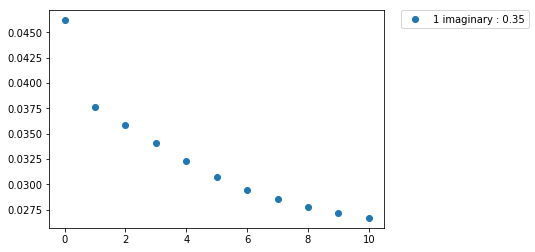

[ 0.0360932   0.02845534  0.02662729  0.0251455   0.0237965   0.02269362
  0.02183894  0.02118516  0.02068108  0.02028357  0.01995601]


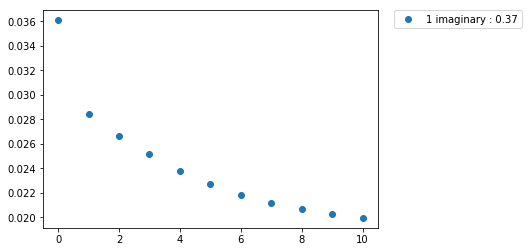

[ 0.03388106  0.02650669  0.02470929  0.02330825  0.02206157  0.02105234
  0.02027429  0.01968113  0.01922494  0.01886589  0.01857035]


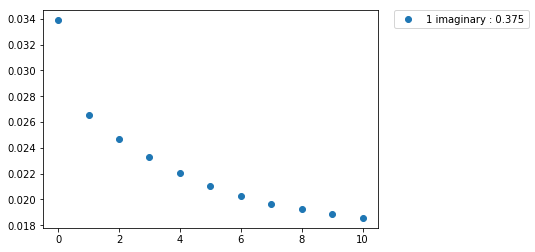

In [178]:
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from matplotlib.font_manager import FontProperties

N = 11 #grid size
thresholds = [0.35, 0.37, 0.375]
for R in thresholds:
    answer1 = np.zeros(N)
    answer2 = np.zeros(N)
    answer3 = np.zeros(N)                          
    for i,  z in enumerate(np.linspace(1, 10, N)):
            '''
            answer1[i] = optimize.newton(f, x0=0.5, args=(R, z), fprime=fd, fprime2=fdd)
            answer2[i] = optimize.newton(f, x0=0.15, args=(R, z), fprime=fd, fprime2=fdd)
            answer3[i] = optimize.newton(f, x0=0.1, args=(R, z), fprime=fd, fprime2=fdd)
            '''
            answer1[i] = optimize.fsolve(f, x0=0.5, args=(R, z))
        
    plt.plot(answer1, "o",  label = "1 imaginary : " + str(R))
    #plt.plot(answer2, "o",  label = "2")
    #plt.plot(answer3, "o",  label = "3")
    print(answer1)
    #print(answer2)
    #print(answer3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    plt.clf()